In [30]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [5]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [6]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'hourly'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

# open precipitation data
fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

# open IVT data
df_lst = []
for i, community in enumerate(community_lst):
    fname = path_to_out + 'IVT_ERA5_{0}.csv'.format(community)
    ivt_df = pd.read_csv(fname)
    
    ## calculate IVT direction
    uvec = units.Quantity(ivt_df['uIVT'].values, "m/s")
    vvec = units.Quantity(ivt_df['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    ivt_df['ivtdir'] = ivtdir
    ivt_df = ivt_df.drop(['Unnamed: 0'], axis=1) # drop unnecessary vars
    
    if temporal_res == 'hourly':
        ivt_df = ivt_df
    elif temporal_res == 'daily':
        ivt_df.index = ivt_df['time']
        ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time'])) # reset the index as "date" 
        ivt_df = ivt_df.resample('1D').mean()
        ivt_df = ivt_df.reset_index() # remove the index
    
    ## append AR data
    fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
    ar_df = pd.read_csv(fname) # read in AR dates

    # append AR dates to current df
    ivt_df['AR'] = ar_df.AR
    
    ## append impact data
    fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
    impact_df = pd.read_csv(fname) # read in impact dates
    # append impact dates to current df
    ivt_df['impact'] = impact_df.IMPACT
    
    # ## append community precipitation data
    ivt_df['prec'] = prec_df[community]
    
    # reset the index as "time"
    ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time']))
    
    ## select the 00, 06, 12, and 18 hour timesteps
    idx = (ivt_df.index.hour == 0) | (ivt_df.index.hour == 6) | (ivt_df.index.hour == 12) | (ivt_df.index.hour == 18)
    ivt_df = ivt_df.loc[idx]
    
    df_lst.append(ivt_df)
    
df_lst[0]


time    IVT   lat     lon   uIVT   vIVT  \
time                                                                          
1980-01-01 00:00:00  1980-01-01 00:00:00  41.78 58.00 -135.50  21.53  35.80   
1980-01-01 06:00:00  1980-01-01 06:00:00  49.11 58.00 -135.50   4.96  48.86   
1980-01-01 12:00:00  1980-01-01 12:00:00  77.47 58.00 -135.50  21.69  74.38   
1980-01-01 18:00:00  1980-01-01 18:00:00  96.64 58.00 -135.50 -30.33  91.75   
1980-01-02 00:00:00  1980-01-02 00:00:00 147.08 58.00 -135.50  -6.52 146.94   
...                                  ...    ...   ...     ...    ...    ...   
2019-12-30 18:00:00  2019-12-30 18:00:00 172.97 58.00 -135.50  64.29 160.58   
2019-12-31 00:00:00  2019-12-31 00:00:00 150.41 58.00 -135.50  94.58 116.96   
2019-12-31 06:00:00  2019-12-31 06:00:00 135.82 58.00 -135.50 114.99  72.28   
2019-12-31 12:00:00  2019-12-31 12:00:00 105.73 58.00 -135.50  72.68  76.79   
2019-12-31 18:00:00  2019-12-31 18:00:00  76.87 58.00 -135.50  37.35  67.18   

                      IWV  ivtdir  AR  impact  prec  
time                                                 
1980-01-01 00:00:00  8.74  211.02   0       0   NaN  
1980-01-01 06:00:00 11.56  185.80   0       0   NaN  
1980-01-01 12:00:00 11.26  196.26   0       0  0.02  
1980-01-01 18:00:00 11.09  161.71   0       0  0.48  
1980-01-02 00:00:00 11.20  177.46   0       0  2.44  
...                   ...     ...  ..     ...   ...  
2019-12-30 18:00:00 14.35  201.82   0       0   NaN  
2019-12-31 00:00:00 14.29  218.96   0       0   NaN  
2019-12-31 06:00:00 12.03  237.85   0       0   NaN  
2019-12-31 12:00:00 13.13  223.42   0       0   NaN  
2019-12-31 18:00:00 12.60  209.07   0       0   NaN  

[58440 rows x 11 columns]

In [19]:
## get list of dates that are Extreme Precip and AR for each community
ardate_lst = []
for i, df in enumerate(df_lst):
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    # idx = (df.AR == 1) & (df.prec > prec_thres) 
    idx = (df.AR == 1) & (df.prec > prec_thres) & (df.index != '2008-02-29 00:00:00') # hack to get rid of the leap day (not in WRF data)
    tmp = df.loc[idx]
    
    ar_dates = tmp.time.values
    ardate_lst.append(tmp.time.values)

## Load Precipitation Data

In [20]:
fname_pattern = path_to_work + 'WRFDS_PCPT_*.nc'
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords')
wrf

<xarray.Dataset>
Dimensions:  (time: 350400, lat: 250, lon: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-12-31T23:00:00
  * lat      (lat) float32 53.12 53.16 53.19 53.23 ... 61.85 61.88 61.92 61.95
  * lon      (lon) float32 -148.1 -148.0 -147.9 -147.9 ... -129.1 -129.0 -128.9
Data variables:
    prec     (time, lat, lon) float32 dask.array<chunksize=(8760, 250, 320), meta=np.ndarray>

In [21]:
## Having trouble with wrf ds not having all the dates in the ar_dates list 
## use this to find out which dates are having a problem
# make a pandas dataframe of AR Dates
answer_lst = []
for i, ar_dates in enumerate(ardate_lst):
    d = {'dates': ar_dates}
    df_A = pd.DataFrame(data=d)
    df_A = df_A.set_index(pd.to_datetime(df_A['dates'])) # reset the index as "dates"


    # make a pandas dataframe of WRF dates
    d = {'dates': wrf.time}
    df_B = pd.DataFrame(data=d)
    df_B = df_B.set_index(pd.to_datetime(df_B['dates'])) # reset the index as "dates"

    # test = df_A.isin(df_B)

    x = df_A.index
    y = df_B.index
    test = x.isin(y)

    idx = (test== False)
    answer = df_A.loc[idx]
    answer_lst.append(answer.dates.values)
answer_lst

[array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object)]

In [24]:
%%time
## make a dataset for each community subset to its AR dates
ds_lst = []
for i, ar_dates in enumerate(ardate_lst):
    print('Processing {0}'.format(community_lst[i]))
    tmp = wrf.sel(time=ar_dates)
    tmp = tmp.mean('time')
    ds_lst.append(tmp.load())
    
ds_lst[0]

Processing Hoonah
Processing Skagway
Processing Klukwan
Processing Yakutat
Processing Craig
Processing Kasaan
CPU times: user 423 ms, sys: 9min 19s, total: 9min 20s
Wall time: 11min 17s


<xarray.Dataset>
Dimensions:  (lat: 250, lon: 320)
Coordinates:
  * lat      (lat) float32 53.12 53.16 53.19 53.23 ... 61.85 61.88 61.92 61.95
  * lon      (lon) float32 -148.1 -148.0 -147.9 -147.9 ... -129.1 -129.0 -128.9
Data variables:
    prec     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Plot Precitation Composites

In [32]:
# Set up projection
mapcrs = ccrs.Mercator()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = wrf.lat.values
lons = wrf.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+1,1)
dy = np.arange(lats.min().round(),lats.max().round()+1,1)

ext1 = [-141., -130., 54., 61.] # extent of SEAK 

3.6624653


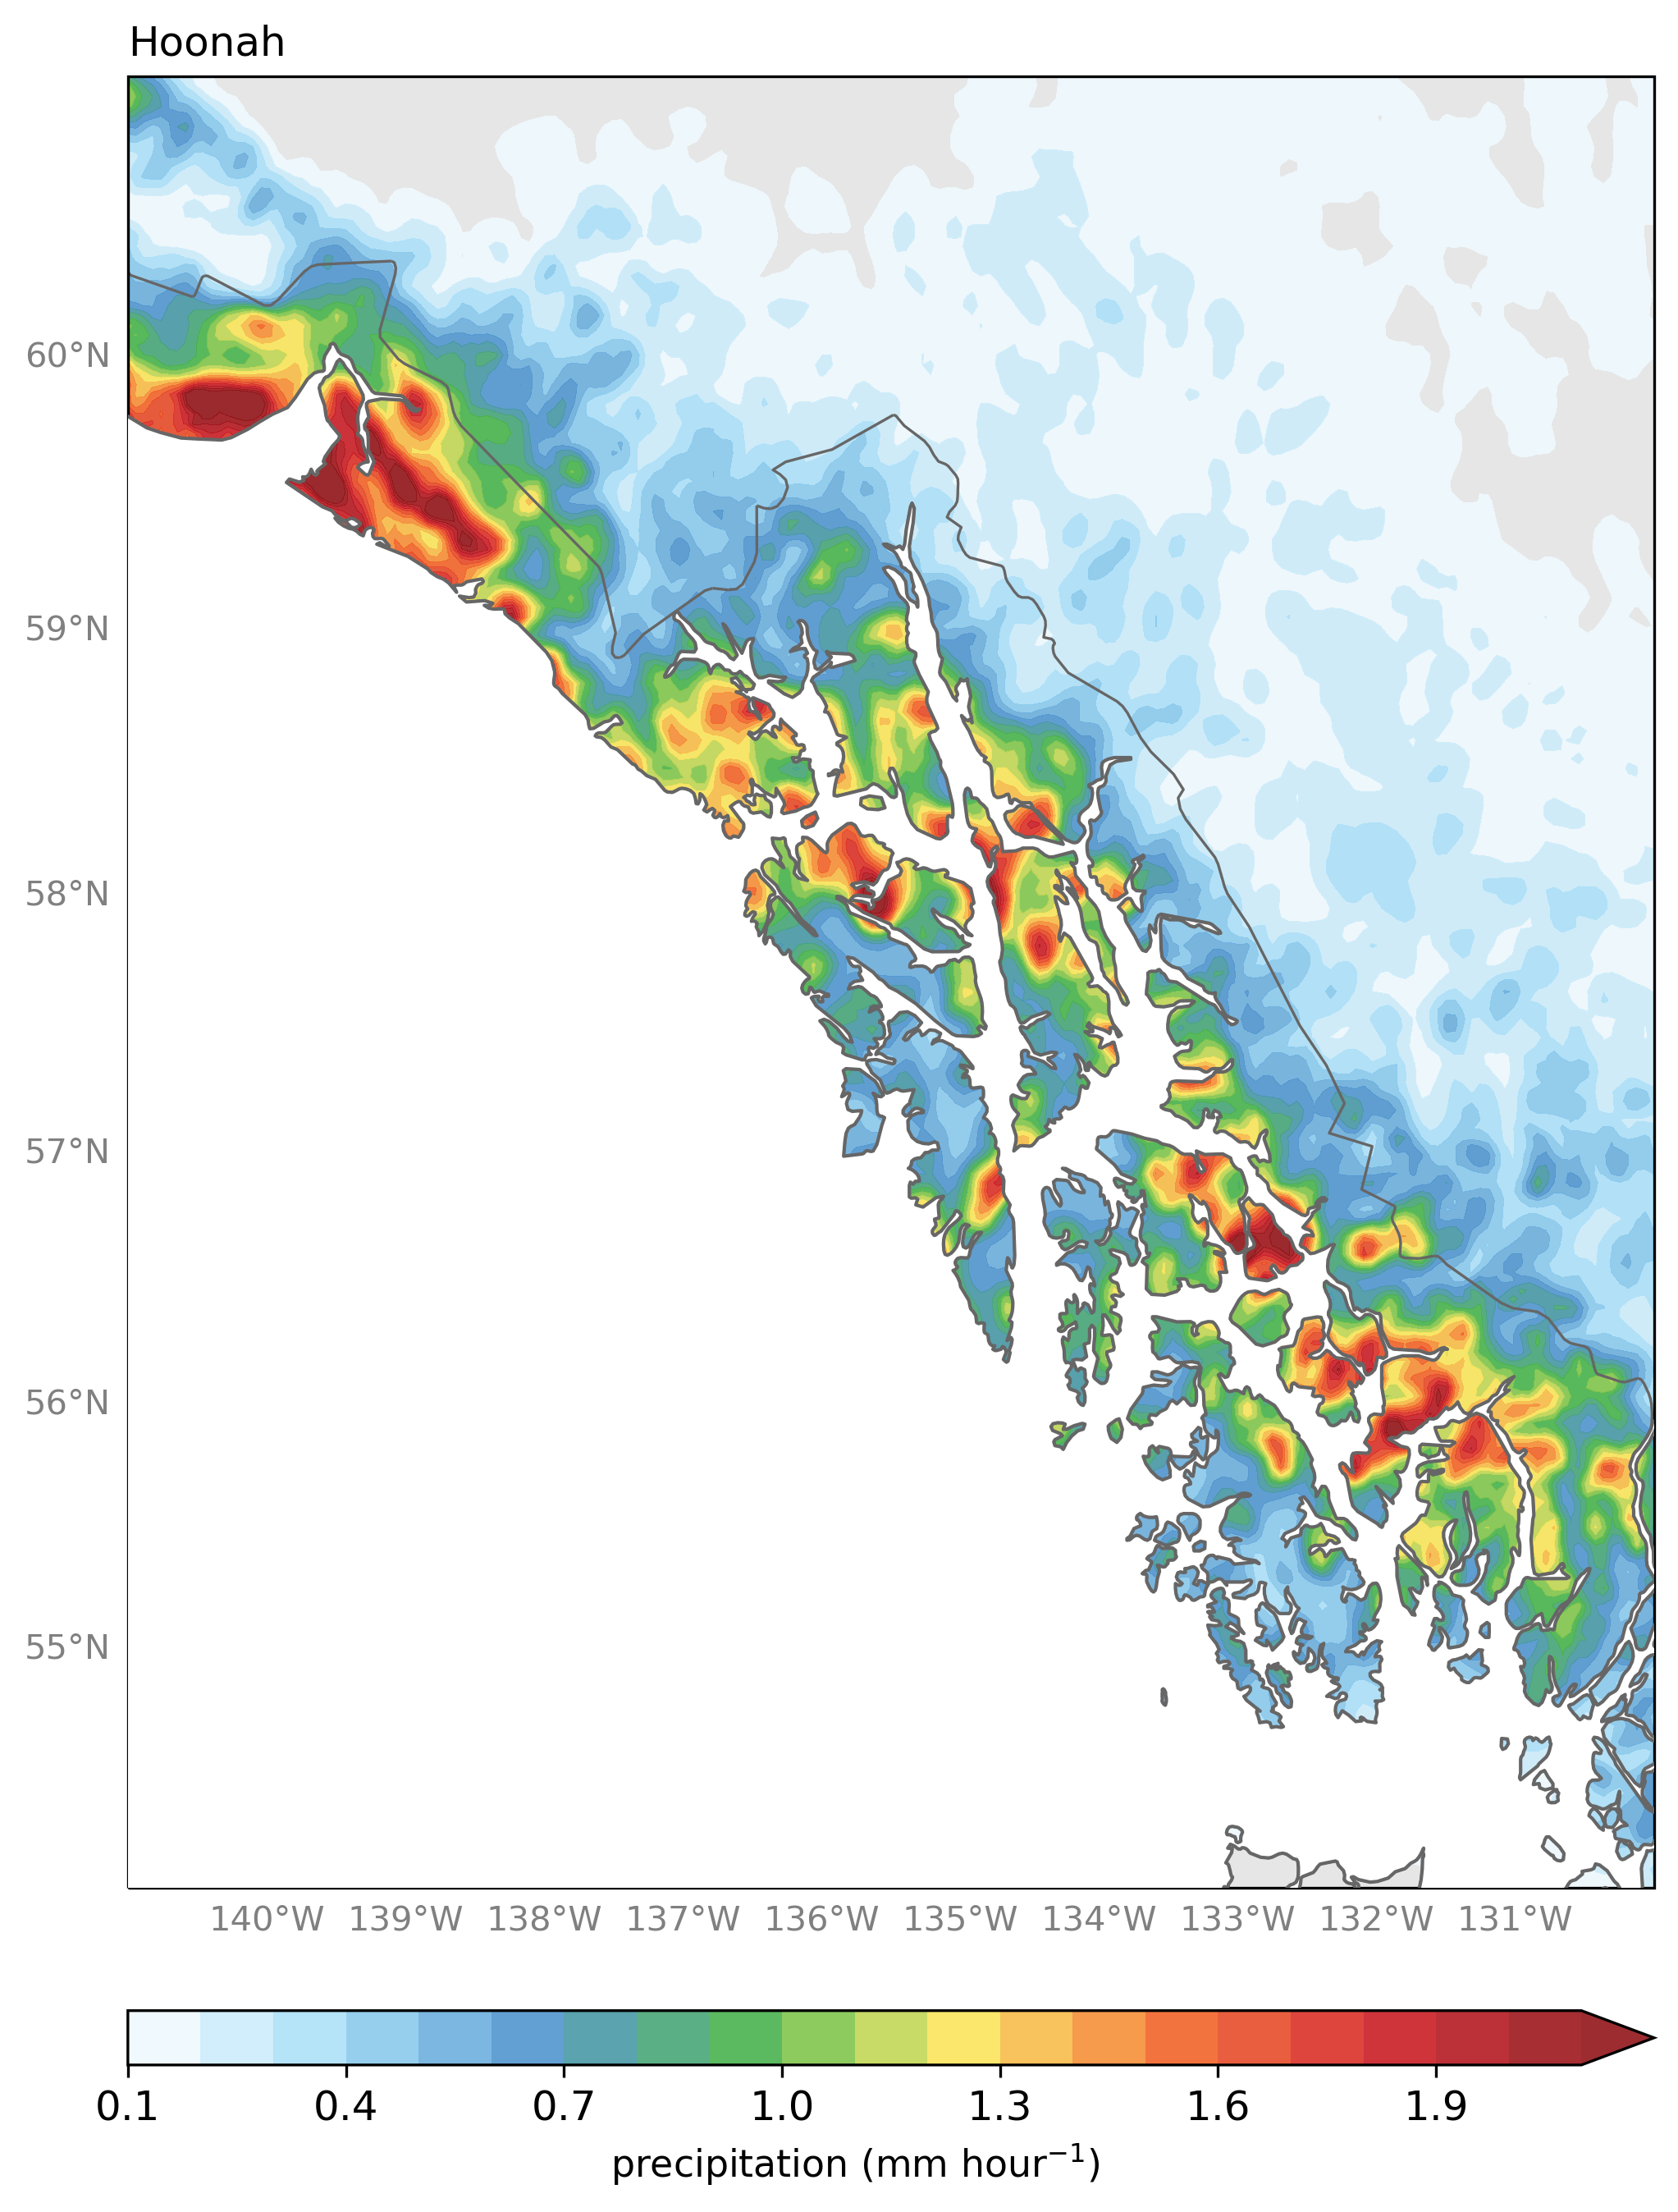

3.150071


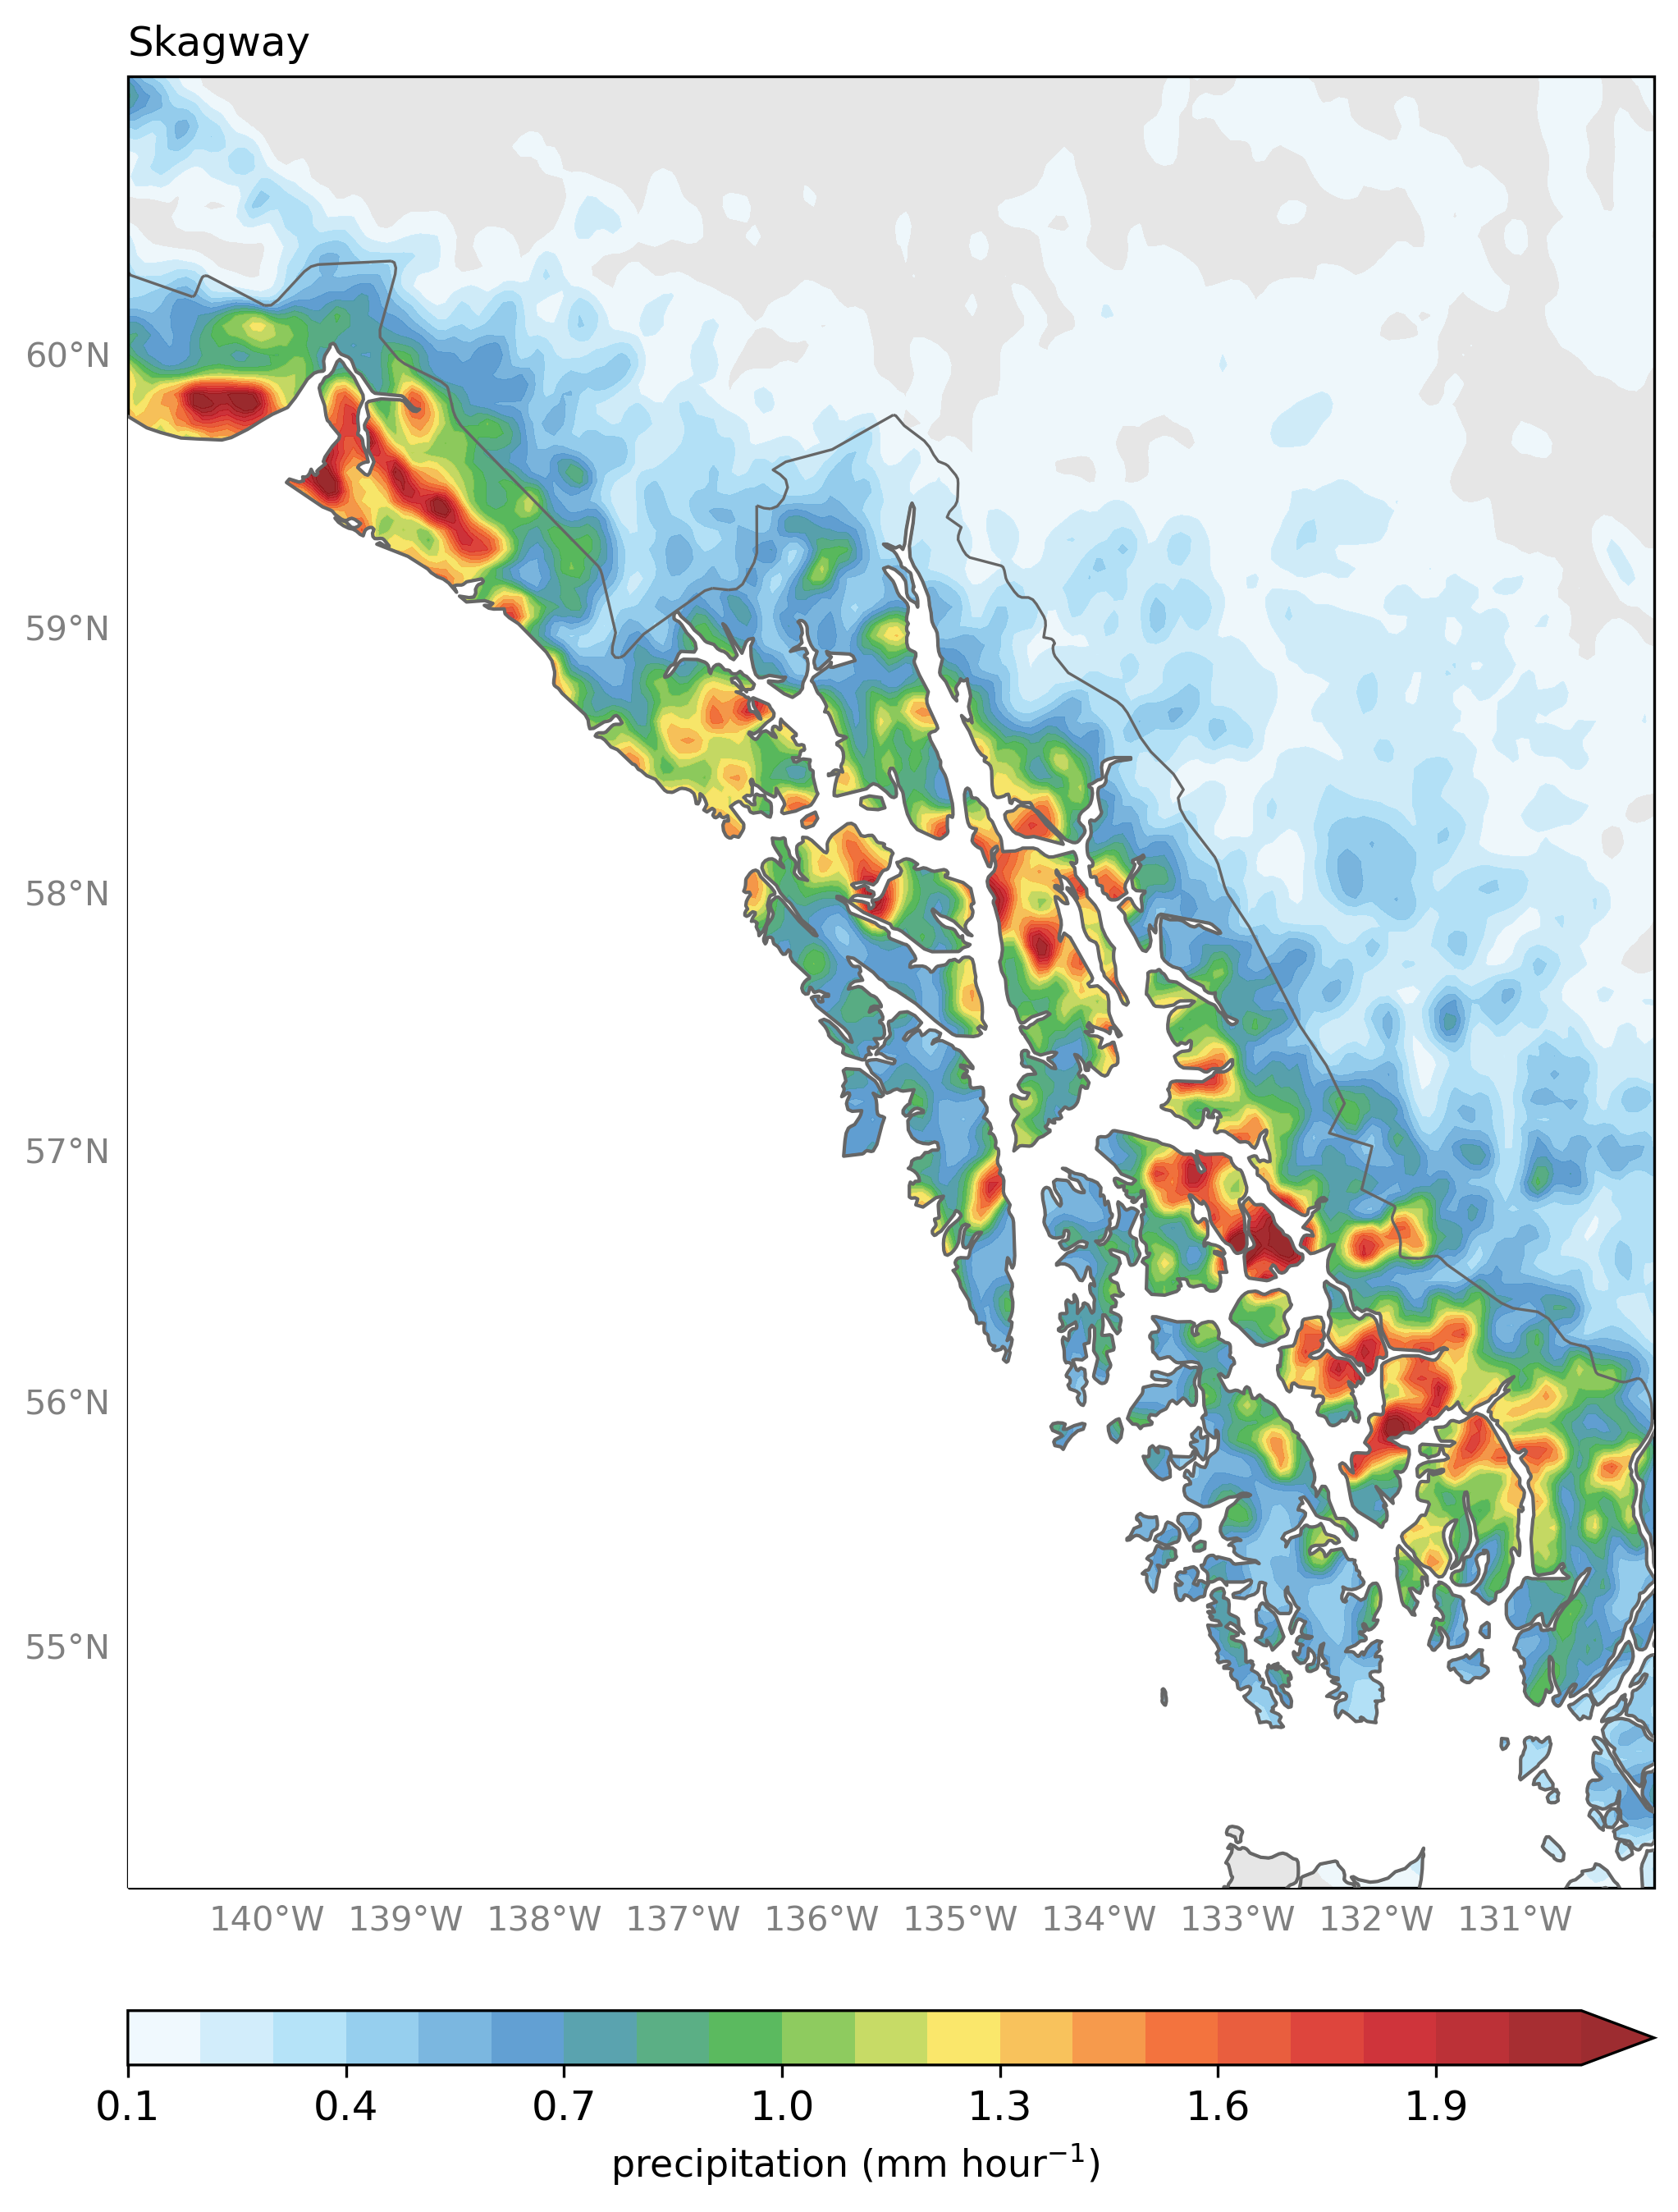

4.1116443


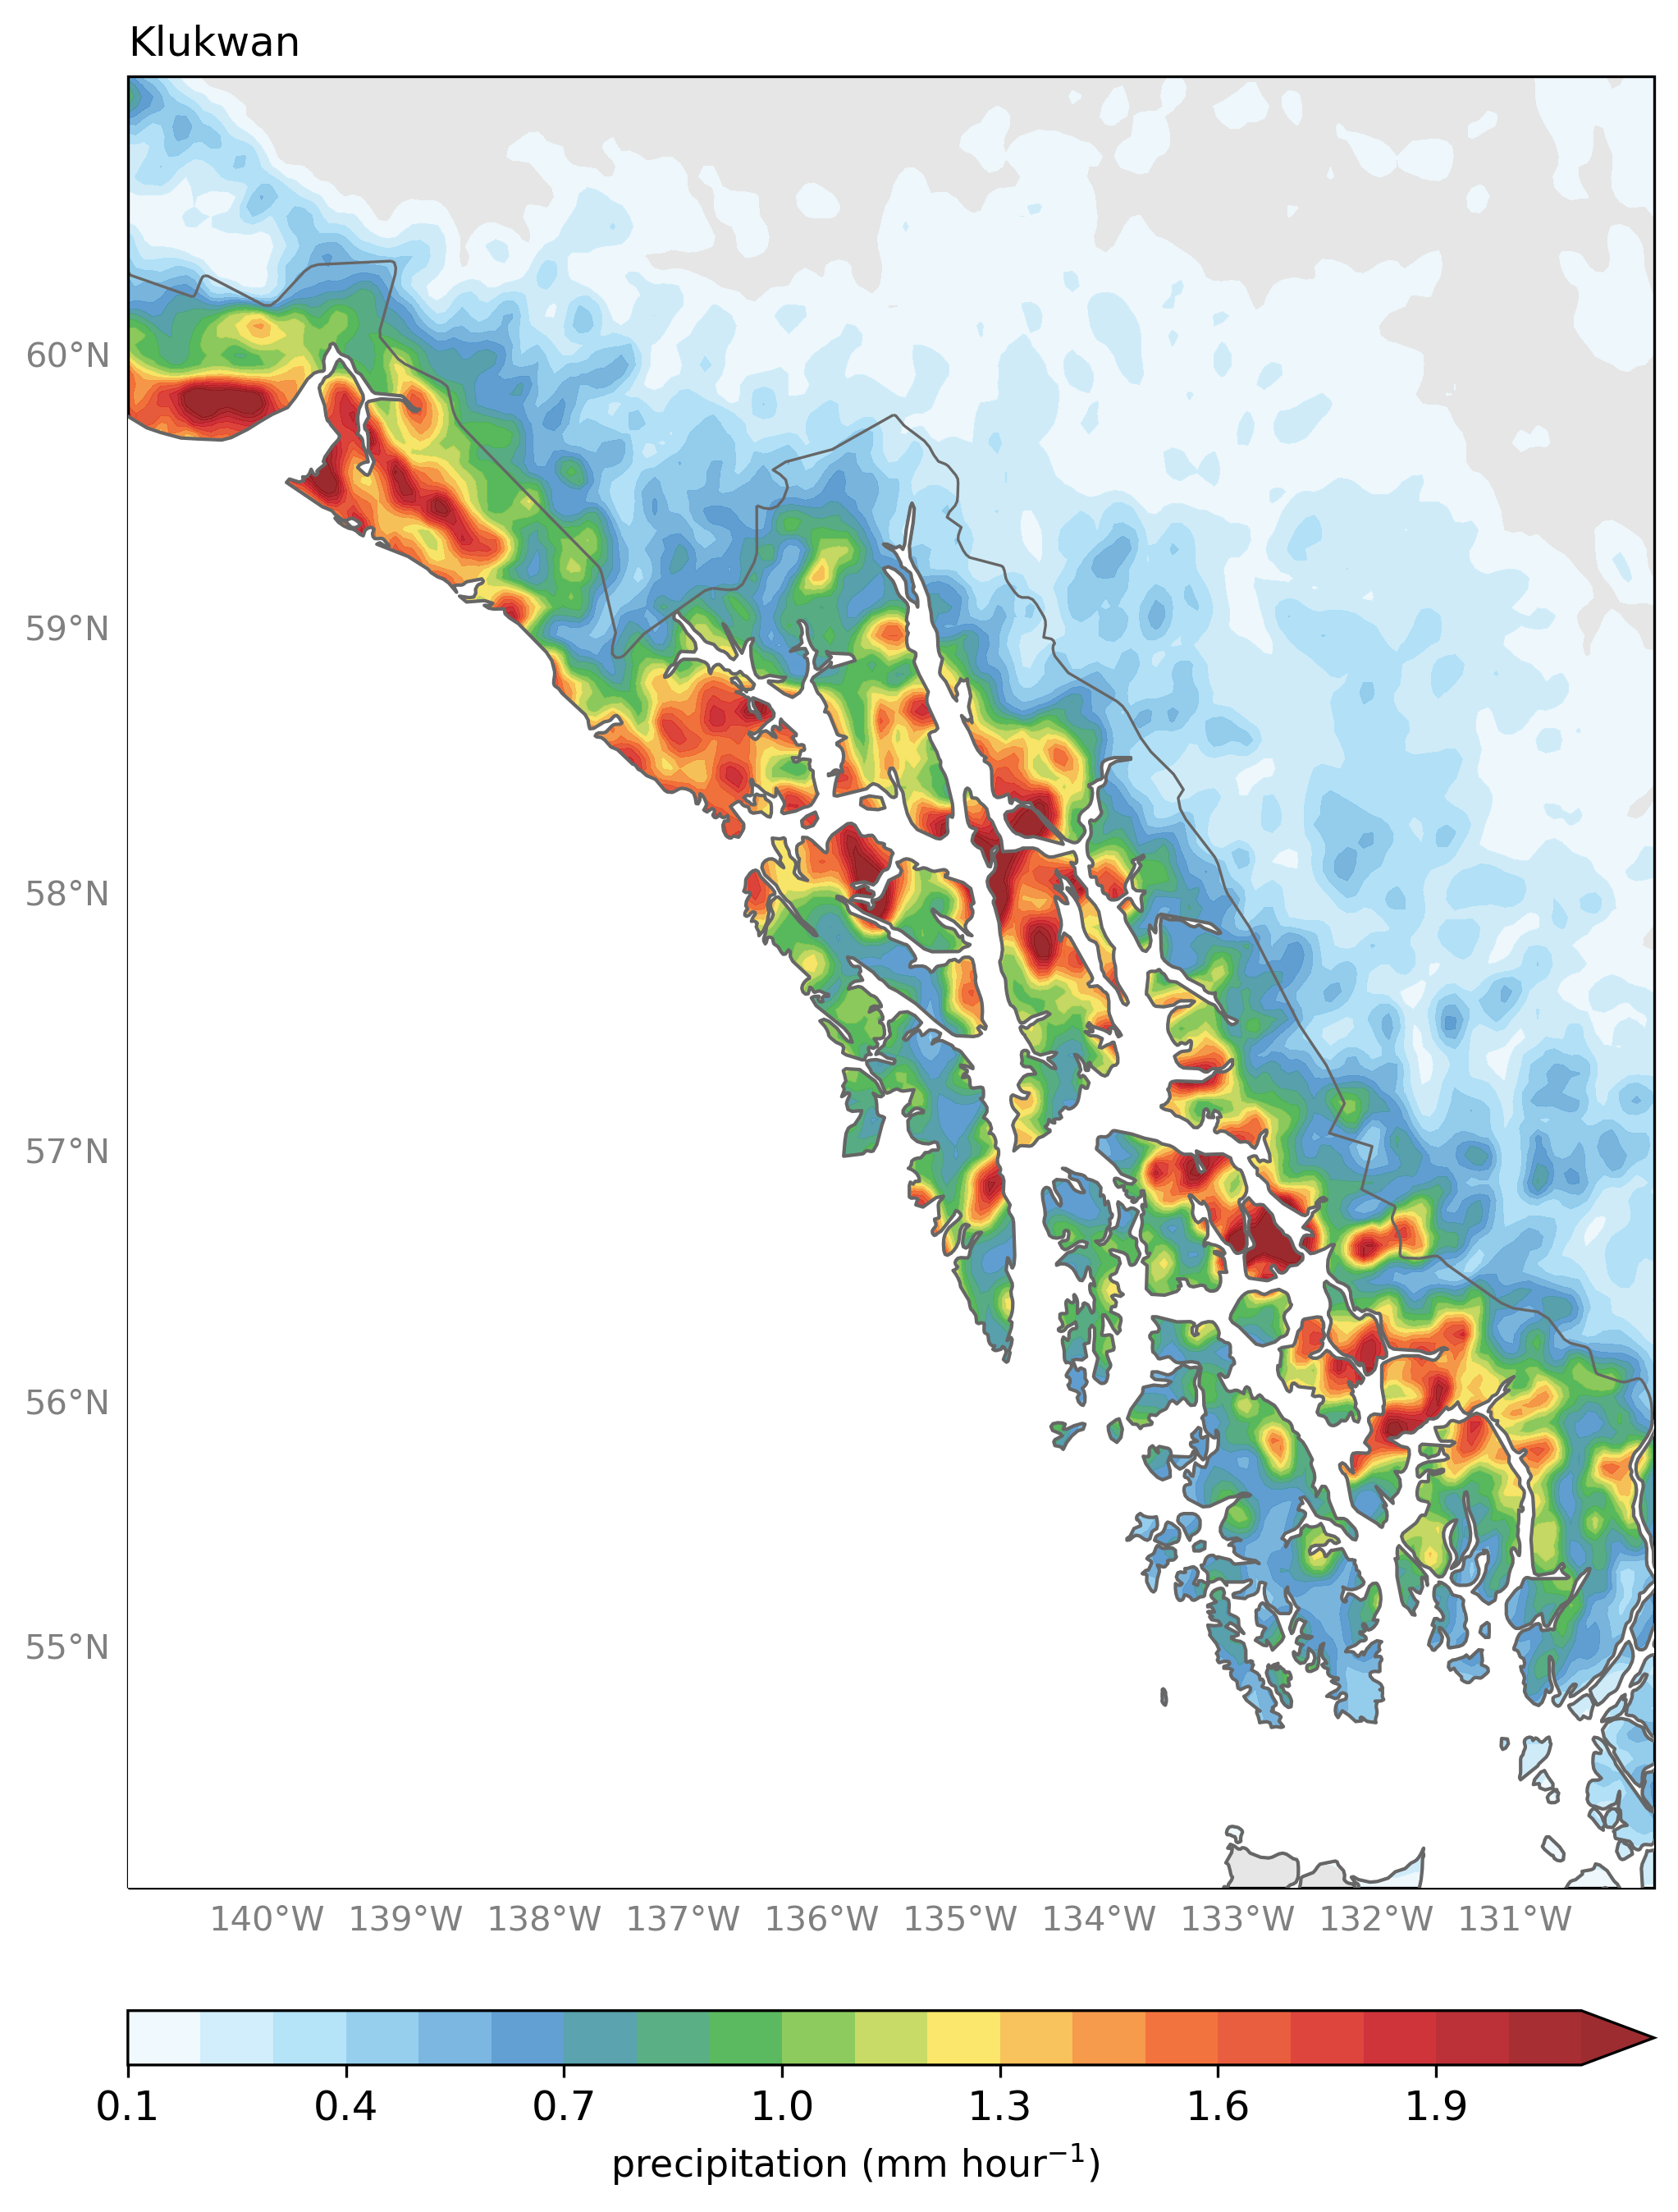

3.5945947


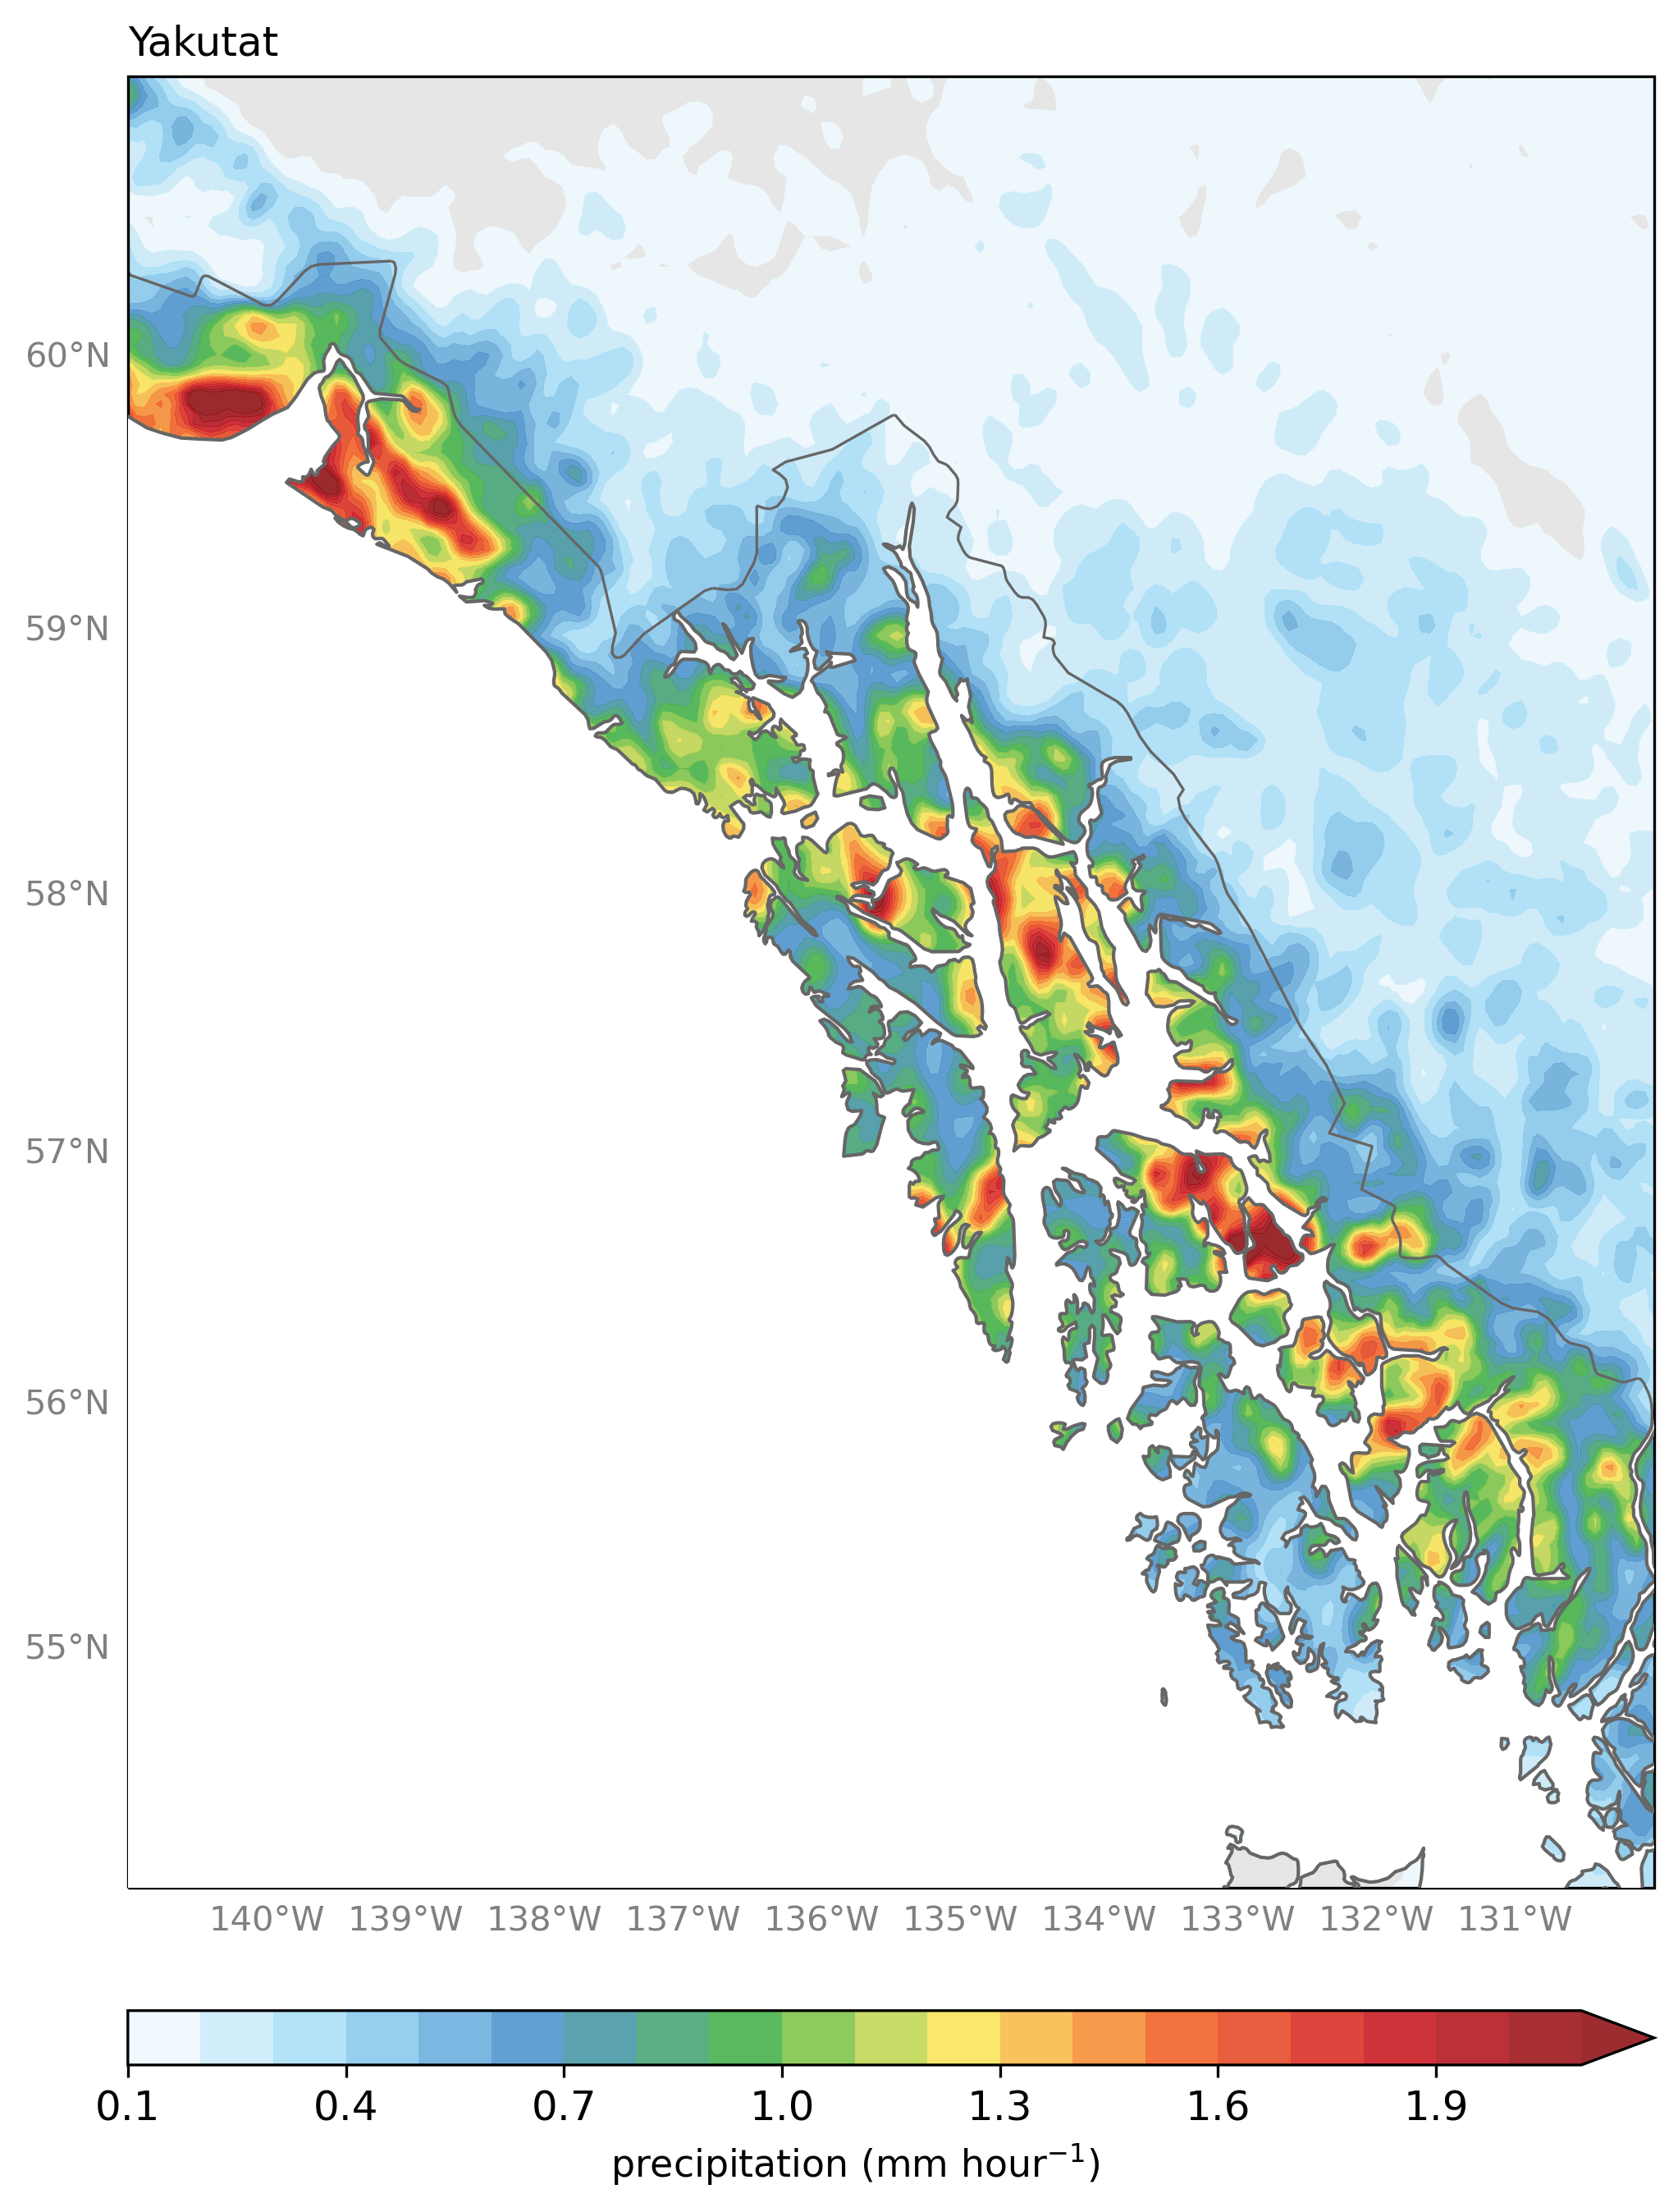

3.9120786


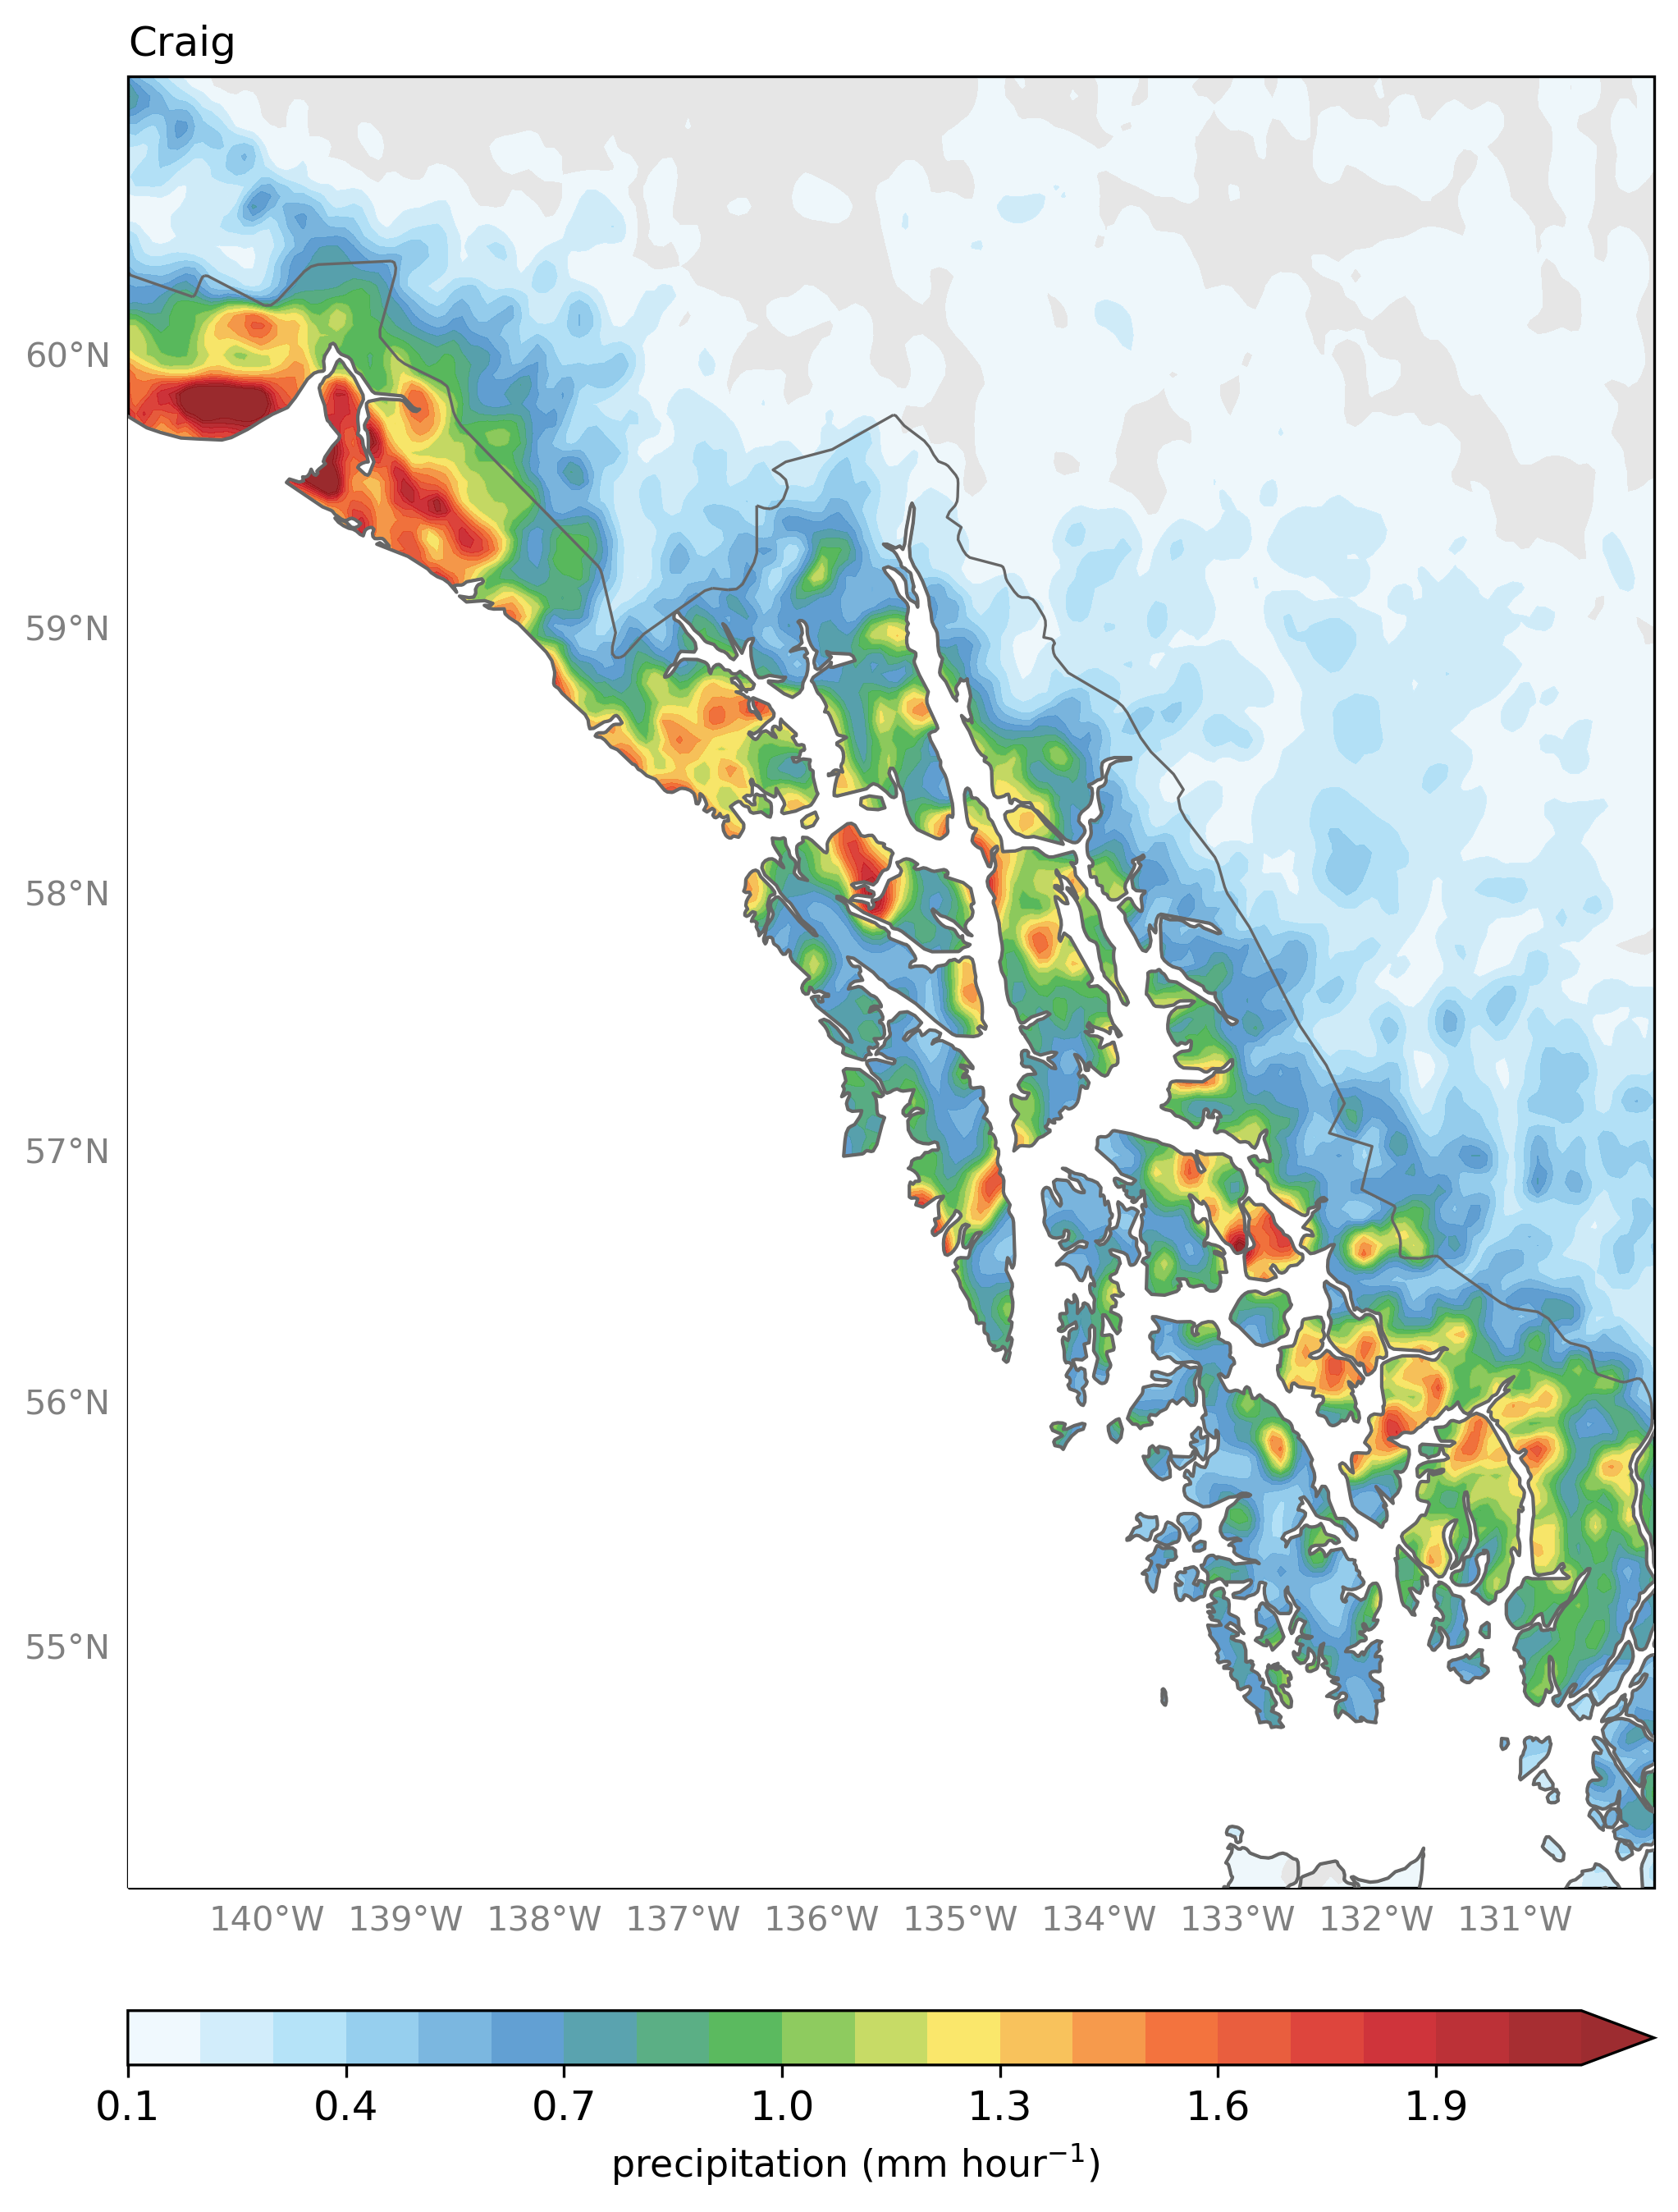

4.625897


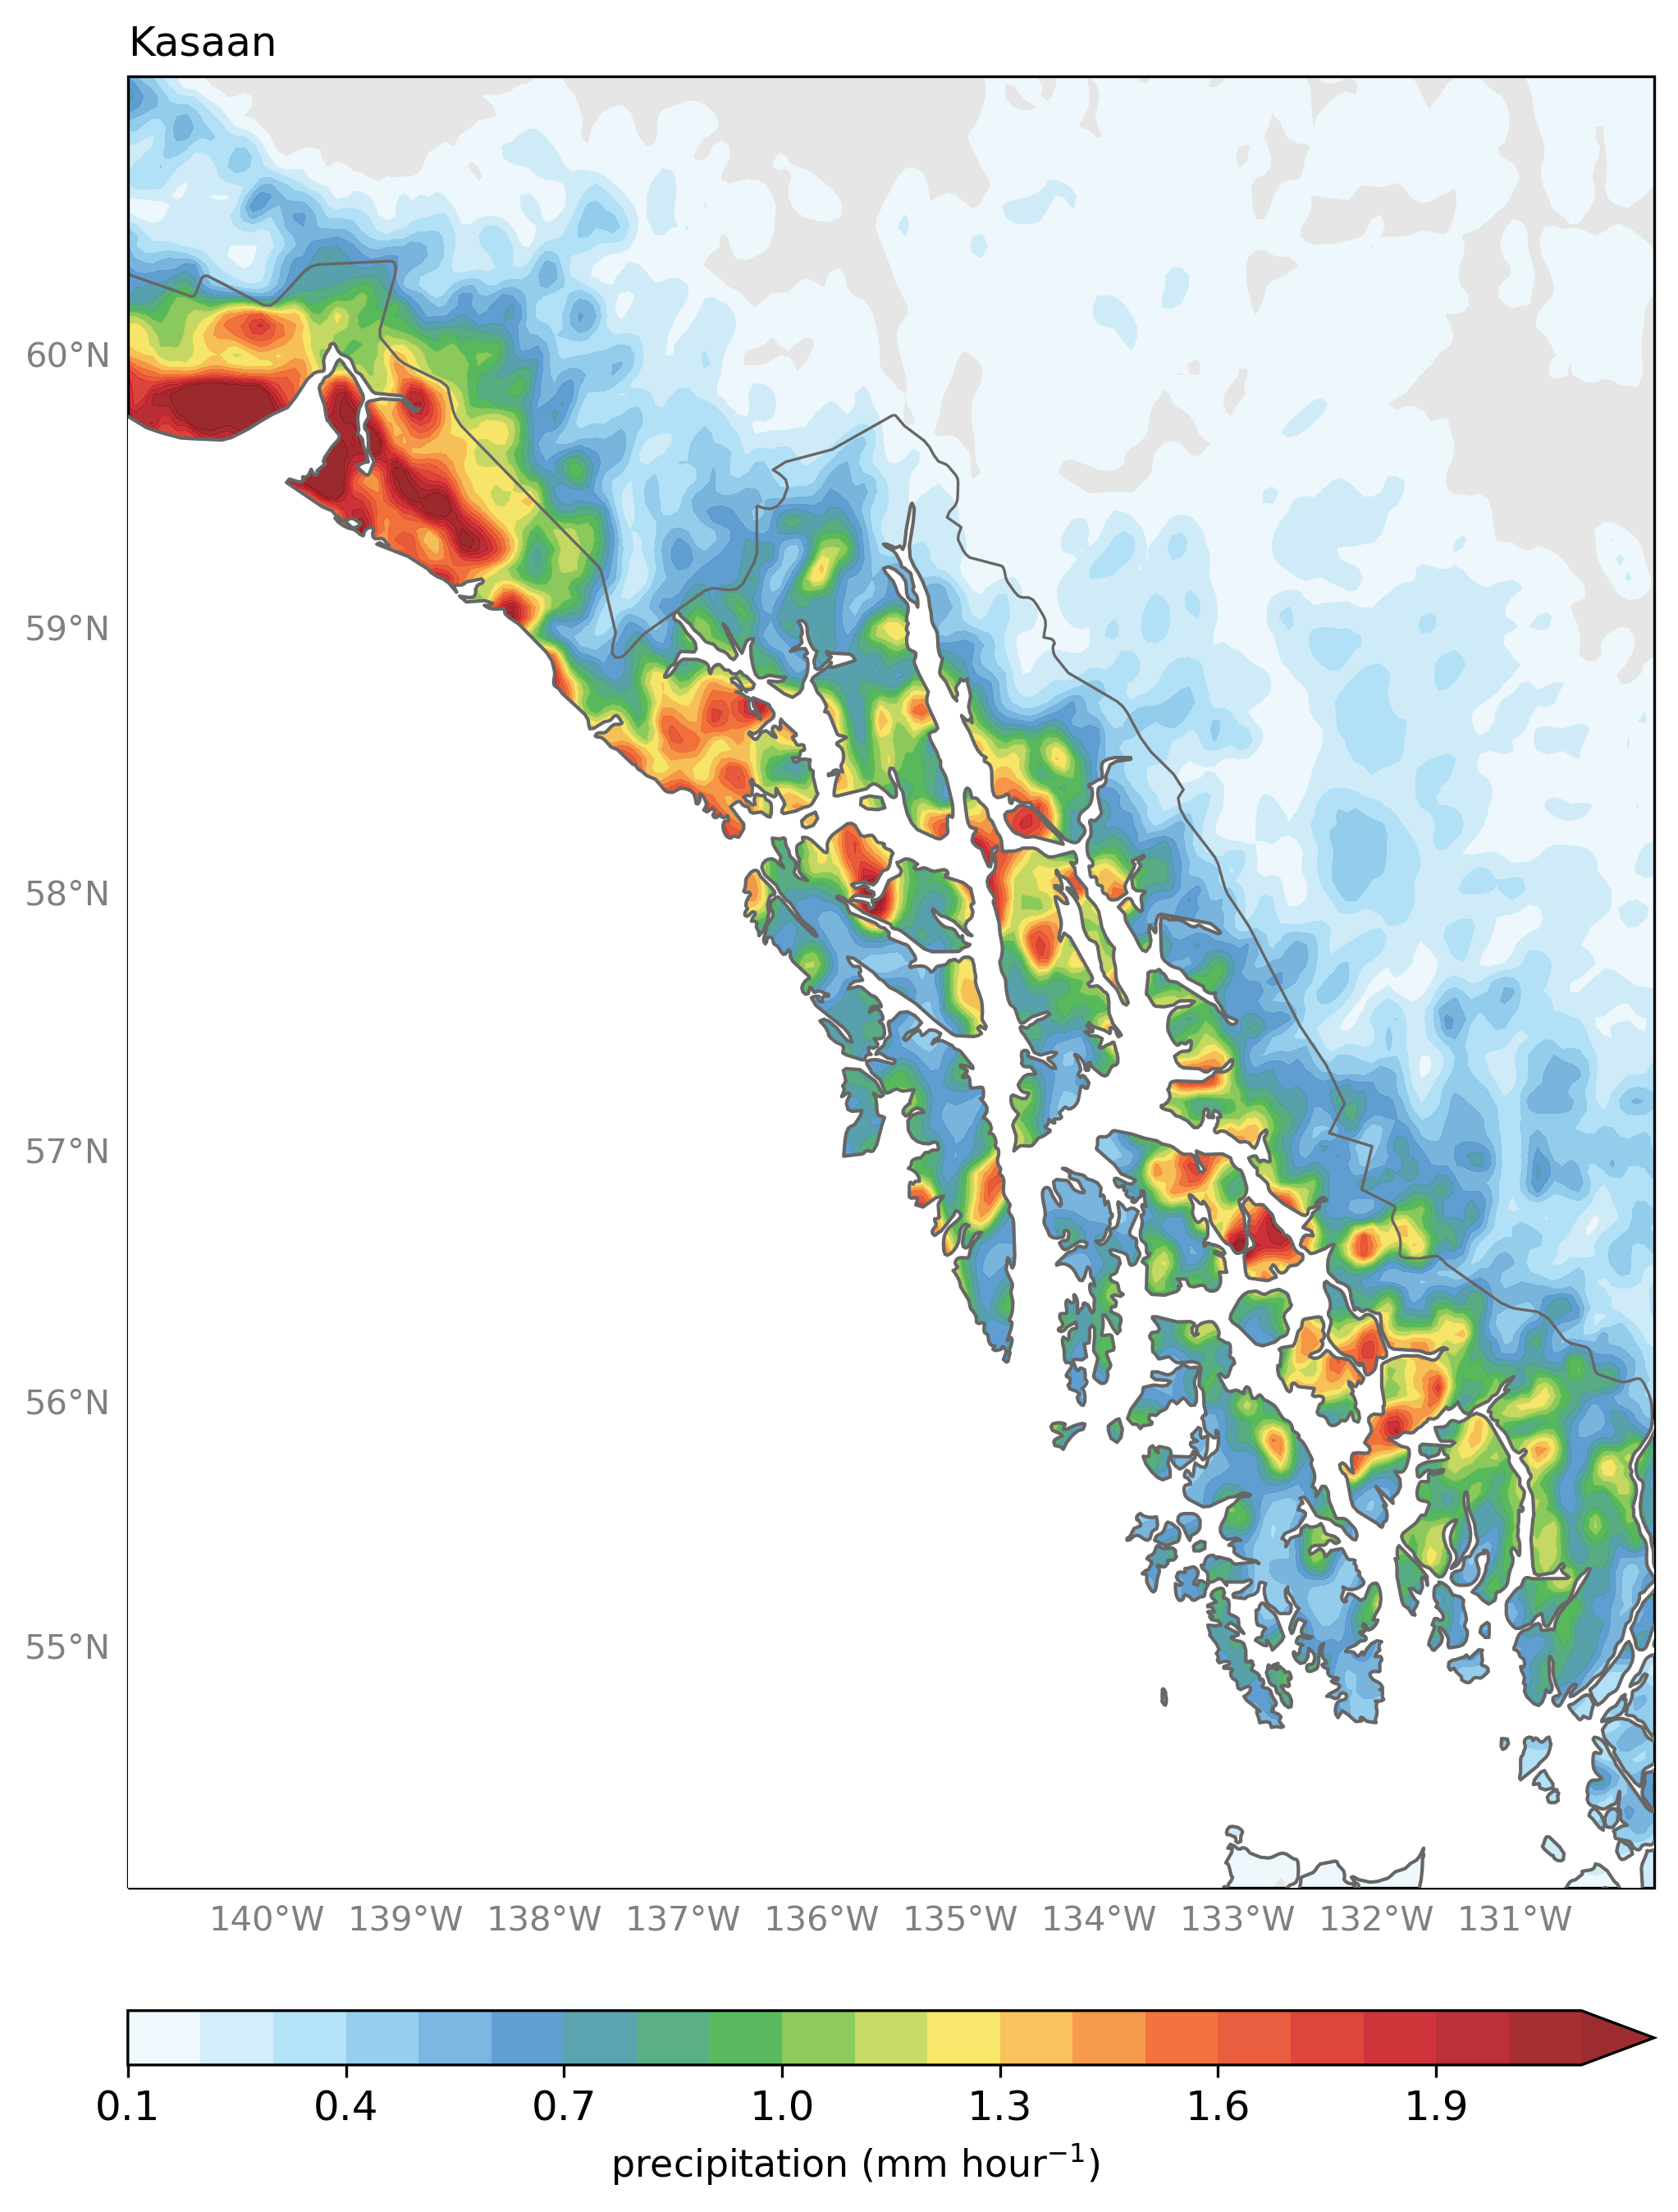

In [42]:
for i, ds in enumerate(ds_lst):
    community = community_lst[i]
    # Create figure
    fig = plt.figure(figsize=(8, 12))
    fig.dpi = 300
    fname = path_to_figs + 'extreme-AR_prec_composite_{0}'.format(community)
    fmt = 'png'

    nrows = 1
    ncols = 1

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='3%',label_mode='')


    for k, ax in enumerate(axgr):
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=True)

        # Contour Filled
        prec = ds.prec.values
        print(np.nanmax(prec))
        cf = ax.contourf(lons, lats, prec, transform=datacrs,
                         levels=np.arange(0.1, 2.2, 0.1), cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')
        
        ax.set_title(community, loc='left')


    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
    cb.set_label('precipitation (mm hour$^{-1}$)', fontsize=11)
    cb.ax.tick_params(labelsize=12)

    fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

    # Show
    plt.show()